In [12]:
import torch
import numpy as np
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.utils.data as Data
import matplotlib.pyplot as plt

In [13]:
data = torch.load('data.pth')
data = Data.TensorDataset(data['feature'], data['label'])
train_set, test_set = random_split(data, [int(50000), int(10000)])

In [14]:
batch_size = 128
train_loader = DataLoader(train_set, batch_size, shuffle=True)
test_loader = DataLoader(test_set, batch_size, shuffle=False)

feature为60000个含有256个特征的向量，label为60000个标签（10）

In [15]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10)
        )
    
    def forward(self, x):
        return self.model(x)

In [16]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [17]:
import torch.utils.cpp_extension

torch.utils.cpp_extension.CUDA_HOME 

In [18]:
print(torch.__version__)

1.13.0


In [19]:
mlp = MLP().to(device)
lossfn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-5)

In [20]:
torch.__version__

'1.13.0'

In [21]:
print(torch.version.cuda)

None


In [22]:
epoch = 1000

all_train_losses = np.zeros(epoch)
all_test_acc = np.zeros(epoch)
best = None
best_acc = 0.0
for i in range(epoch):
    mlp.train(True)
    train_losses = []
    for input, target in train_loader:
        input, target = input.to(device), target.to(device)
        optimizer.zero_grad()
        out = mlp(input)
        loss = lossfn(out, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    train_loss = np.mean(train_losses)
    mlp.train(False)
    test_acc = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
        outputs = mlp(inputs)
        idx = torch.argmax(outputs, dim=1)
        correct = (idx == targets).sum().item()
        n = targets.shape[0]
        test_acc.append(correct/n)
    acc = np.mean(test_acc)
    all_train_losses[i] = train_loss
    all_test_acc[i] = acc
    if i % 25 == 0:
        print("epoch " + str(i) + ": " + str(round(acc, 5)))
    if acc > best_acc:
        best_acc = acc
        best = mlp.state_dict()



epoch 0: 0.67642
epoch 25: 0.95669
epoch 50: 0.96796
epoch 75: 0.97172
epoch 100: 0.97389
epoch 125: 0.97369
epoch 150: 0.9735
epoch 175: 0.97449
epoch 200: 0.97389
epoch 225: 0.97419
epoch 250: 0.97488
epoch 275: 0.97538
epoch 300: 0.97379
epoch 325: 0.97528
epoch 350: 0.97468
epoch 375: 0.97498
epoch 400: 0.97518
epoch 425: 0.97528
epoch 450: 0.97488
epoch 475: 0.97488
epoch 500: 0.97656
epoch 525: 0.97567
epoch 550: 0.97587
epoch 575: 0.97627
epoch 600: 0.97577
epoch 625: 0.97636
epoch 650: 0.97567
epoch 675: 0.97597
epoch 700: 0.97538
epoch 725: 0.97627
epoch 750: 0.97577
epoch 775: 0.97676
epoch 800: 0.97706
epoch 825: 0.97636
epoch 850: 0.97567
epoch 875: 0.97755
epoch 900: 0.97518
epoch 925: 0.97666
epoch 950: 0.97666
epoch 975: 0.97518


In [23]:
torch.save(best, 'model.pth')
print(best_acc)

0.9776503164556962


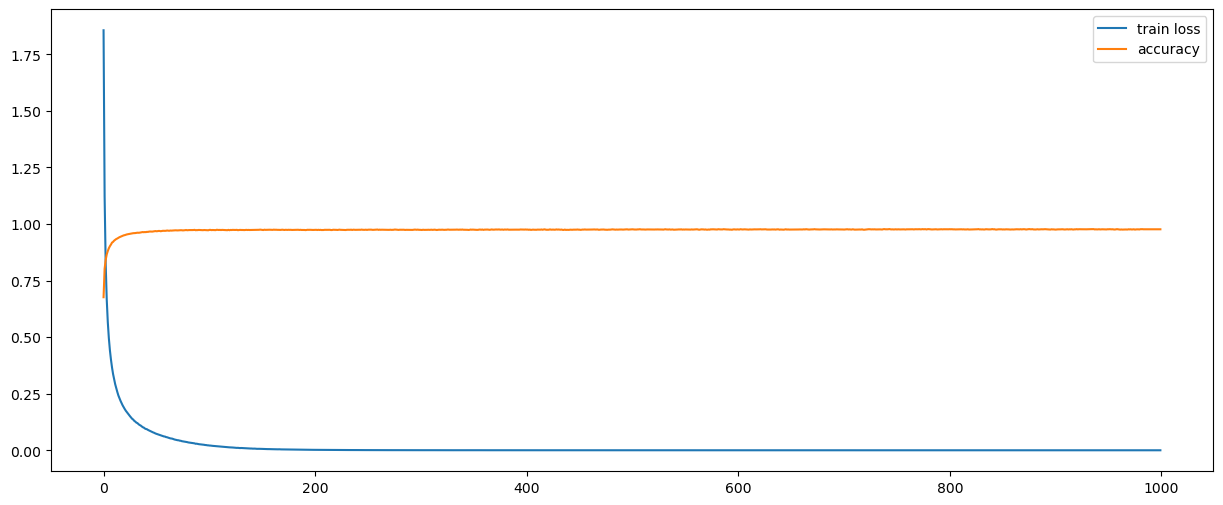

In [24]:
plt.figure(figsize=(15,6))
plt.plot(all_train_losses, label='train loss')
plt.plot(all_test_acc, label='accuracy')

plt.legend()

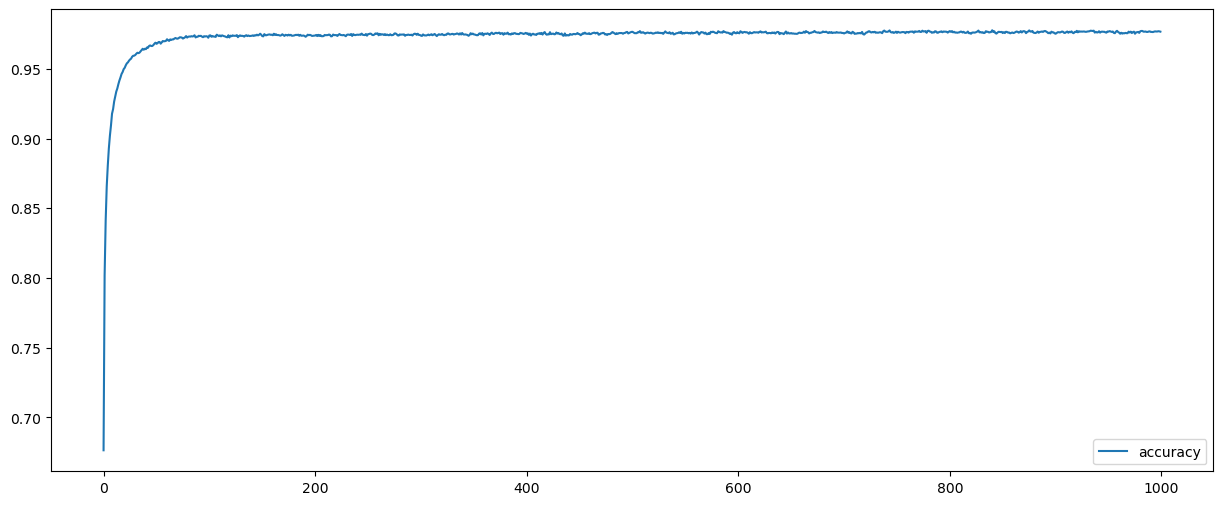

In [25]:
plt.figure(figsize=(15,6))
plt.plot(all_test_acc, label='accuracy')

plt.legend()

In [26]:
correct = 0
n = 0

for input, target in test_loader:
    input, target = input.to(device), target.to(device)
    out = mlp(input)
    idx = torch.argmax(out, dim=1)
    correct += (idx == target).sum().item()
    n += target.shape[0]

acc = correct/n
print(acc)

0.9764
